In [2]:
from plugins.calibration.sn_calibration_baseline.camera import Camera
import cv2
from matplotlib import pyplot as plt
from copy import deepcopy
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import json
import os
import numpy as np
import scipy.signal

plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
camParamsPath = "Labels-GameState360.json"
imgPath = 'Images/360/'
maskPath = 'out360/tta/'
imgNum = 225

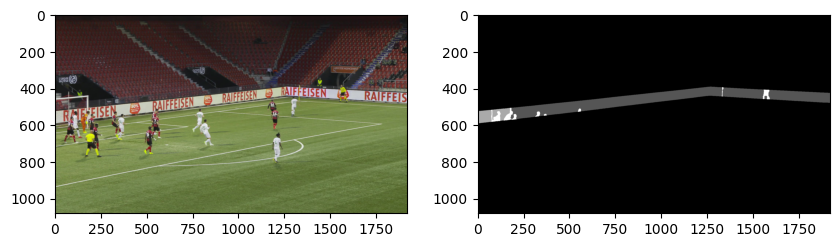

In [4]:
with open(camParamsPath, "r") as f:
	camParams = json.load(f)["annotations"]
camParams = [x["parameters"] for x in camParams if x["supercategory"] == "camera"]
cam = Camera()
cam.from_json_parameters(camParams[imgNum - 1])  # camParams is 0-indexed whereas img_num is 1-indexed
img = cv2.imread(imgPath + str(imgNum).zfill(6) + '.jpg')
mask = cv2.imread(maskPath + str(imgNum).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
# plot img and mask side by side
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

{'pan_degrees': -36.460170350411786, 'tilt_degrees': 84.1956383327518, 'roll_degrees': -0.08990616781472739, 'position_meters': [0.5487823024733196, 49.54517288350619, -8.708467462637122], 'x_focal_length': 5206.254284220787, 'y_focal_length': 5206.254284223689, 'principal_point': [960.0, 540.0], 'radial_distortion': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'tangential_distortion': [0.0, 0.0], 'thin_prism_distortion': [0.0, 0.0, 0.0, 0.0]}


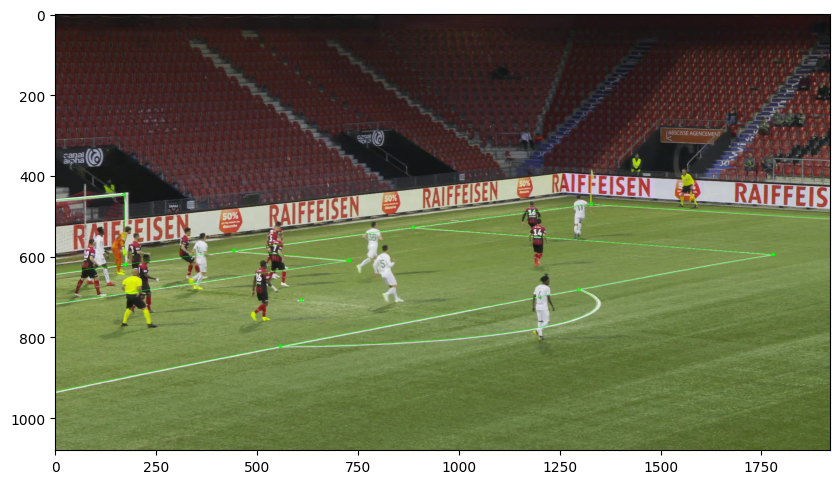

In [5]:
plt.imshow(cv2.cvtColor(cam.draw_corners(cam.draw_pitch(img)), cv2.COLOR_BGR2RGB))
print(camParams[imgNum - 1])

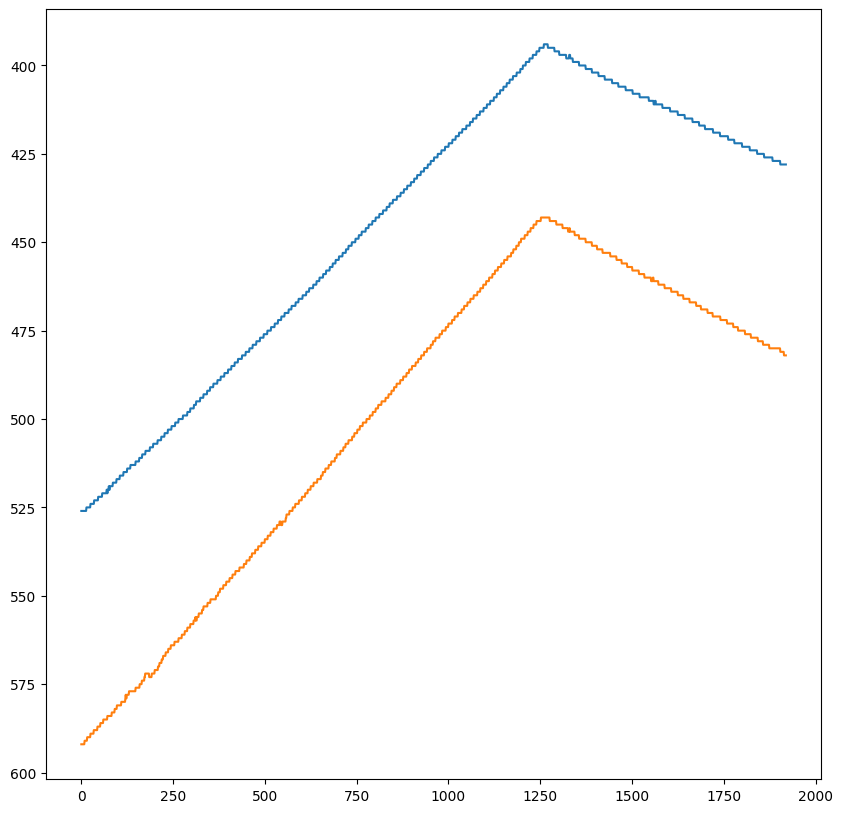

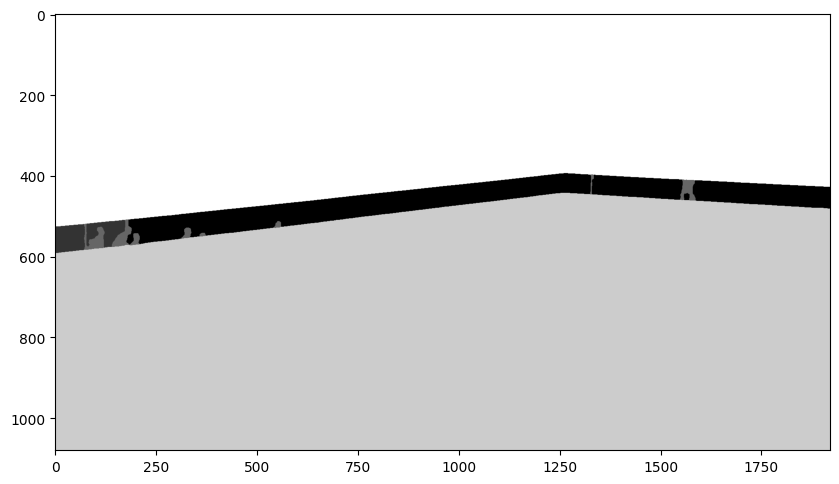

In [6]:
binMask = np.uint8(mask > 0)
firstNonZeroIdx = np.argmax(binMask, axis=0)
firstNonZeroIdx[firstNonZeroIdx == 0] = -1
plt.plot(firstNonZeroIdx)
flipped = cv2.flip(binMask, 0)
flippedLastNonZeroIdx = np.argmax(flipped, axis=0)
lastNonZeroIdx = mask.shape[0] - flippedLastNonZeroIdx - 1
lastNonZeroIdx[lastNonZeroIdx == mask.shape[0] - 1] = -1
plt.plot(lastNonZeroIdx)
plt.gca().invert_yaxis()
plt.show()
tmp = deepcopy(mask)
for i in range(mask.shape[1]):
	tmp[lastNonZeroIdx[i]:, i] = 5
	tmp[:firstNonZeroIdx[i], i] = 6
plt.imshow(tmp, cmap='gray')

In [7]:
points2D = np.array([[x, y] for x, y in zip(np.where(lastNonZeroIdx != -1)[0], lastNonZeroIdx[lastNonZeroIdx != -1])])
print(points2D.shape, points2D)
unprojectedPoints = np.array([cam.unproject_point_on_planeZ0(p, undistort=False) for p in points2D])
unprojectedPoints

(1920, 2) [[   0  592]
 [   1  592]
 [   2  592]
 ...
 [1917  482]
 [1918  482]
 [1919  482]]


array([[-57.23482834,  -4.39496543,  -0.        ],
       [-57.22290436,  -4.40403907,  -0.        ],
       [-57.21098031,  -4.41311276,  -0.        ],
       ...,
       [-42.53471483, -38.77009259,  -0.        ],
       [-42.51987306, -38.78146401,  -0.        ],
       [-42.50503118, -38.79283551,  -0.        ]])

In [8]:
tmppt = unprojectedPoints[0]
tmppt[2] = -1
z1m = cam.project_point(tmppt, distort=False)
print(z1m[1], lastNonZeroIdx[0], firstNonZeroIdx[0])
realz = (lastNonZeroIdx[0] - firstNonZeroIdx[0]) / (lastNonZeroIdx[1] - z1m[1])
print(realz)

525.7497121556886 592 526
0.9962220866888974


In [9]:
unprojectedPoints[:, 2] = -1
z1m = [cam.project_point(p, distort=False)[1] for p in unprojectedPoints]
realz = (lastNonZeroIdx[firstNonZeroIdx != -1] - firstNonZeroIdx[firstNonZeroIdx != -1]) / (lastNonZeroIdx[firstNonZeroIdx != -1] - z1m)
maxz = np.mean(realz)
print(maxz)

0.9810642095859804


In [10]:
closestTo0X = np.mean(unprojectedPoints[np.bitwise_and(unprojectedPoints[:, 1] >= -68/2, unprojectedPoints[:, 1] <= 68/2)][:, 0])
closestTo0X

-57.07651866505802

[[-5646.04123415  1230.2396702 ]
 [-5657.97292038  1057.46896987]
 [ 1129.50915295   408.43666396]
 [ 1129.19862267   458.59873744]]


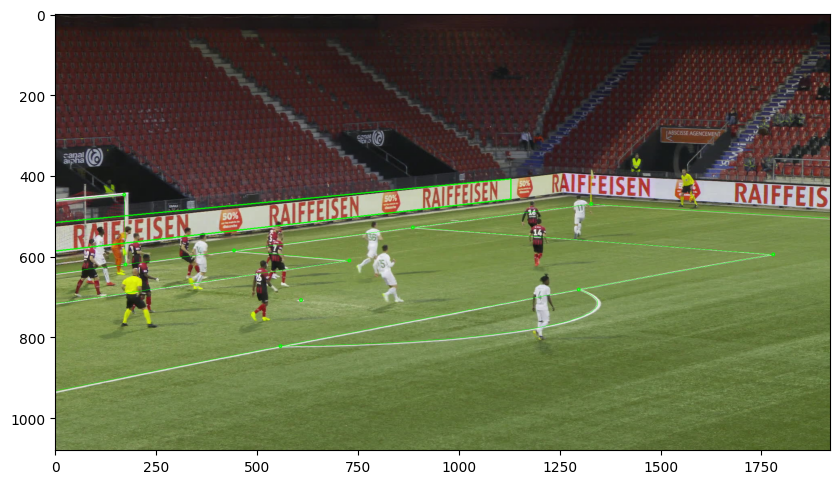

In [11]:
pts = [[closestTo0X, 68/2, 0], [closestTo0X, 68/2, -maxz], [closestTo0X, -68/2, -maxz], [closestTo0X, -68/2, 0]]
pts = np.array([cam.project_point(p, distort=True) for p in pts])[:, :2]
print(pts)
tmpImg = deepcopy(img)
cv2.polylines(tmpImg, [pts.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
plt.imshow(cv2.cvtColor(tmpImg, cv2.COLOR_BGR2RGB))

[[-5596.04123415  1280.2396702 ]
 [-5607.97292038  1107.46896987]
 [ 1179.50915295   458.43666396]
 [ 1179.19862267   508.59873744]]
[[ 1.00000000e+00  1.14426048e-15  5.00000000e+01]
 [-1.80718462e-16  1.00000000e+00  5.00000000e+01]
 [-4.40146924e-19 -4.92939972e-19  1.00000000e+00]]
[[ 3.61917048e+03 -3.86269012e+03  1.90166212e+05]
 [ 2.04086566e-01 -1.34709440e+01  4.62488796e+04]
 [-5.91217052e-01 -8.00146680e-01  4.08485601e+01]]
{'pan_degrees': -36.46017035041179, 'tilt_degrees': 84.1956383327518, 'roll_degrees': -0.0899061678147274, 'position_meters': [0.5487823024733196, 49.54517288350619, -8.708467462637122], 'x_focal_length': 5206.254284220787, 'y_focal_length': 5206.254284223689, 'principal_point': [960.0, 540.0], 'radial_distortion': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'tangential_distortion': [0.0, 0.0], 'thin_prism_distortion': [0.0, 0.0, 0.0, 0.0]}
{'pan_degrees': -36.73396576358012, 'tilt_degrees': 84.74210767998382, 'roll_degrees': -0.0899061678655462, 'position_meters':

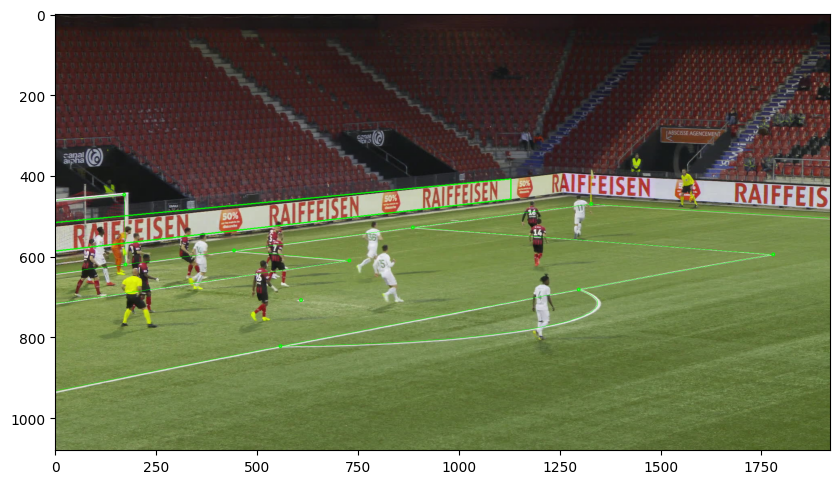

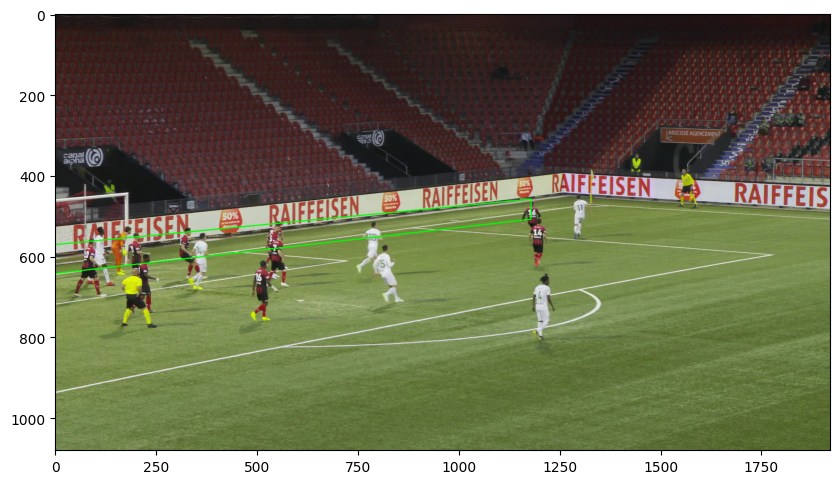

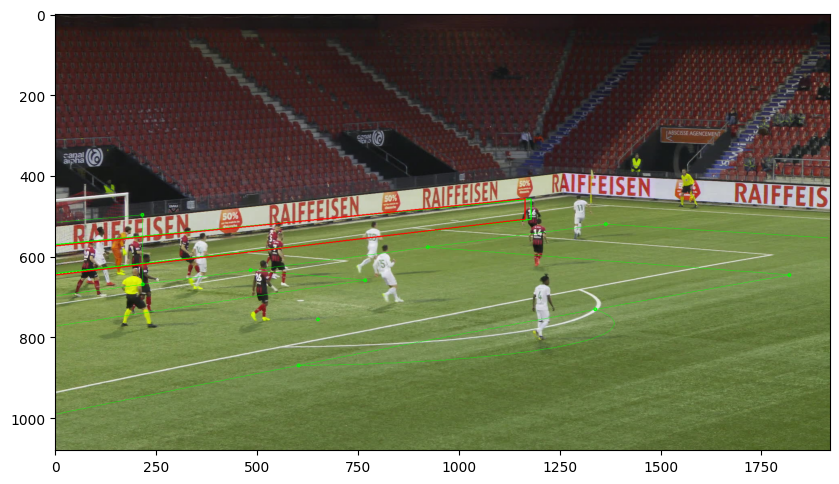

In [12]:
# test of correcting the camera parameters

cam.from_json_parameters(camParams[imgNum - 1])
pts = [[closestTo0X, 68/2, 0], [closestTo0X, 68/2, -maxz], [closestTo0X, -68/2, -maxz], [closestTo0X, -68/2, 0]]
pts = np.array([cam.project_point(p, distort=True) for p in pts])[:, :2]
tmpImg = cv2.imread(imgPath + str(imgNum).zfill(6) + '.jpg')
cv2.polylines(tmpImg, [pts.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
plt.imshow(cv2.cvtColor(cam.draw_corners(cam.draw_pitch(tmpImg)), cv2.COLOR_BGR2RGB))
ptsCorrected = pts + 50
print(ptsCorrected)
tmpImg = cv2.imread(imgPath + str(imgNum).zfill(6) + '.jpg')
cv2.polylines(tmpImg, [ptsCorrected.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
plt.figure()
plt.imshow(cv2.cvtColor(tmpImg, cv2.COLOR_BGR2RGB))
Mcorrected = cv2.getPerspectiveTransform(pts.astype(np.float32), ptsCorrected.astype(np.float32))
print(Mcorrected)
previousM = cam.to_homography()
print(previousM)
print(cam.to_json_parameters())
cam2 = Camera()
cam2.from_json_parameters(cam.to_json_parameters())
cam2.from_homography(Mcorrected @ previousM)
# cam2.xfocal_length = cam.xfocal_length
# cam2.yfocal_length = cam.yfocal_length
# cam2.principal_point = cam.principal_point
print(cam2.to_json_parameters())
# cam.from_homography(np.dot(Mcorrected, previousM))
# %timeit Mcorrected @ previousM
# %timeit np.dot(Mcorrected, previousM)

pts2 = [[closestTo0X, 68/2, 0], [closestTo0X, 68/2, -maxz], [closestTo0X, -68/2, -maxz], [closestTo0X, -68/2, 0]]
pts2 = np.array([cam2.project_point(p, distort=True) for p in pts2])[:, :2]
cv2.polylines(tmpImg, [pts2.astype(np.int32)], isClosed=True, color=(0, 0, 255), thickness=2)

plt.figure()
plt.imshow(cv2.cvtColor(cam2.draw_corners(cam2.draw_pitch(tmpImg)), cv2.COLOR_BGR2RGB))

In [13]:
def rotation_matrix_to_pan_tilt_roll(rotation):
    """
    Decomposes the rotation matrix into pan, tilt and roll angles. There are two solutions, but as we know that cameramen
    try to minimize roll, we take the solution with the smallest roll.
    :param rotation: rotation matrix
    :return: pan, tilt and roll in radians
    """
    orientation = np.transpose(rotation)
    first_tilt = np.arccos(orientation[2, 2])
    second_tilt = - first_tilt

    sign_first_tilt = 1. if np.sin(first_tilt) > 0. else -1.
    sign_second_tilt = 1. if np.sin(second_tilt) > 0. else -1.

    first_pan = np.arctan2(sign_first_tilt * orientation[0, 2], sign_first_tilt * - orientation[1, 2])
    second_pan = np.arctan2(sign_second_tilt * orientation[0, 2], sign_second_tilt * - orientation[1, 2])
    first_roll = np.arctan2(sign_first_tilt * orientation[2, 0], sign_first_tilt * orientation[2, 1])
    second_roll = np.arctan2(sign_second_tilt * orientation[2, 0], sign_second_tilt * orientation[2, 1])

    # print(f"first solution {first_pan*180./np.pi}, {first_tilt*180./np.pi}, {first_roll*180./np.pi}")
    # print(f"second solution {second_pan*180./np.pi}, {second_tilt*180./np.pi}, {second_roll*180./np.pi}")
    if np.fabs(first_roll) < np.fabs(second_roll):
        return first_pan, first_tilt, first_roll
    return second_pan, second_tilt, second_roll

In [14]:
def pan_tilt_roll_to_orientation(pan, tilt, roll):
    """
    Conversion from euler angles to orientation matrix.
    :param pan:
    :param tilt:
    :param roll:
    :return: orientation matrix
    """
    Rpan = np.array([
        [np.cos(pan), -np.sin(pan), 0],
        [np.sin(pan), np.cos(pan), 0],
        [0, 0, 1]])
    Rroll = np.array([
        [np.cos(roll), -np.sin(roll), 0],
        [np.sin(roll), np.cos(roll), 0],
        [0, 0, 1]])
    Rtilt = np.array([
        [1, 0, 0],
        [0, np.cos(tilt), -np.sin(tilt)],
        [0, np.sin(tilt), np.cos(tilt)]])
    rotMat = np.dot(Rpan, np.dot(Rtilt, Rroll))
    return rotMat

(1080, 1920, 3)
{'pan_degrees': -36.46017035041179, 'tilt_degrees': 84.1956383327518, 'roll_degrees': -0.0899061678147274, 'position_meters': [0.5487823024733196, 49.54517288350619, -8.708467462637122], 'x_focal_length': 5206.254284220787, 'y_focal_length': 5206.254284223689, 'principal_point': [960.0, 540.0], 'radial_distortion': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'tangential_distortion': [0.0, 0.0], 'thin_prism_distortion': [0.0, 0.0, 0.0, 0.0]}
True
[[-1.43018354]
 [ 0.49540627]
 [ 0.50867719]]
[[29.2633618 ]
 [ 3.77273939]
 [40.09552778]]
[-37.21077316  85.51651064   1.00073225]
[ 0.72125277 49.22278559 -7.40448699]
{'pan_degrees': -37.21077316278258, 'tilt_degrees': 85.51651064411116, 'roll_degrees': 1.00073225494419, 'position_meters': [0.7212527668966473, 49.22278559394394, -7.40448698812204], 'x_focal_length': 5206.254284220787, 'y_focal_length': 5206.254284223689, 'principal_point': [960.0, 540.0], 'radial_distortion': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'tangential_distortion': [0.0

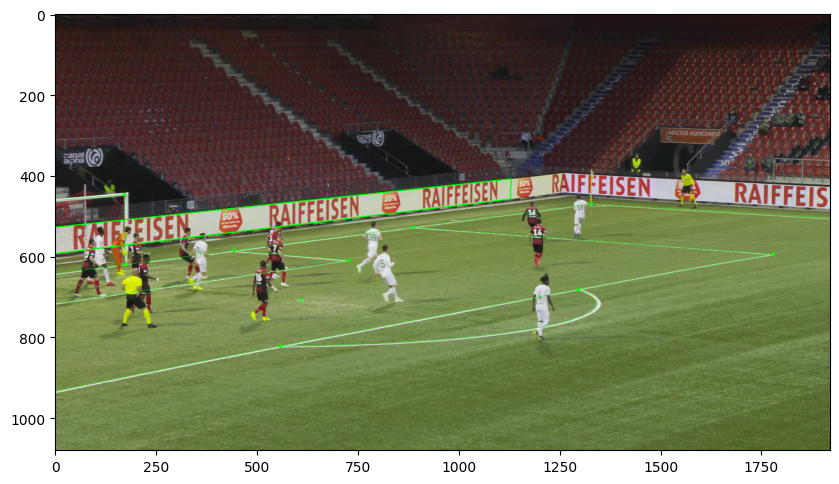

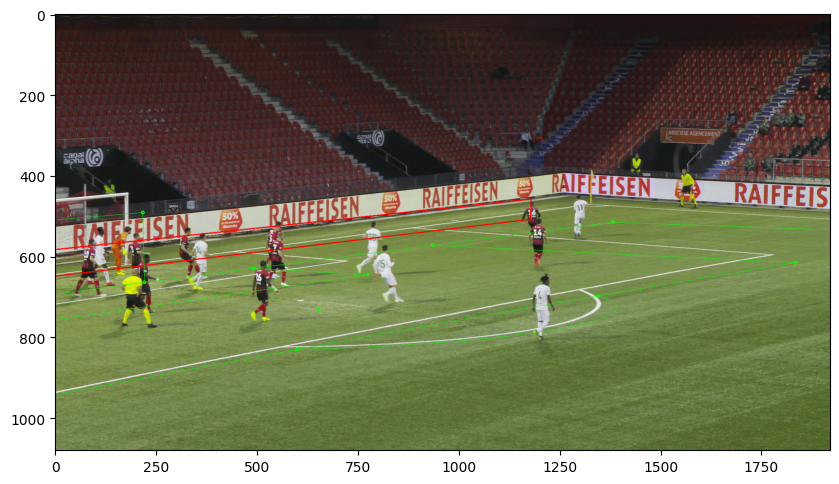

In [15]:
# test of correcting the camera parameters

cam.from_json_parameters(camParams[imgNum - 1])
pts = [[closestTo0X, 68/2, 0], [closestTo0X, 68/2, -maxz], [closestTo0X, -68/2, -maxz], [closestTo0X, -68/2, 0]]
pts = np.array([cam.project_point(p, distort=False) for p in pts])[:, :2]
tmpImg = cv2.imread(imgPath + str(imgNum).zfill(6) + '.jpg')
print(tmpImg.shape)
cv2.polylines(tmpImg, [pts.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
plt.imshow(cv2.cvtColor(cam.draw_corners(cam.draw_pitch(tmpImg)), cv2.COLOR_BGR2RGB))
print(cam.to_json_parameters())
# use solvePnP to get the camera parameters
objectPoints = np.array([[closestTo0X, 68/2, 0], [closestTo0X, 68/2, -maxz], [closestTo0X, -68/2, -maxz], [closestTo0X, -68/2, 0]], dtype=np.float64)
imagePoints = np.array([cam.project_point(p, distort=False)[:2] for p in objectPoints], dtype=np.float64)
cameraMatrix = np.array(cam.calibration, dtype=np.float64)
imagePoints += 50
# # Reshape objectPoints to be Nx1 3-channel array
# objectPoints = objectPoints.reshape(-1, 1, 3)
# # Reshape imagePoints to be Nx1 2-channel array
# imagePoints = imagePoints.reshape(-1, 1, 2)
# print(objectPoints, imagePoints, sep='\n')
dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
(ret, rvec, tvec) = cv2.solvePnP(objectPoints, imagePoints, cameraMatrix, dist_coeffs, flags=cv2.SOLVEPNP_P3P)
print(ret, rvec, tvec, sep='\n')

rotation, _ = cv2.Rodrigues(rvec)
position = - np.transpose(rotation) @ tvec.flatten()
pan, tilt, roll = rotation_matrix_to_pan_tilt_roll(rotation)
if -np.pi/2 > pan or pan > np.pi/2:
	dpi = -np.sign(pan) * np.pi
	pan += dpi
	roll *=-1
	position[2] *= -1
rotation = np.transpose(pan_tilt_roll_to_orientation(pan, tilt, roll))
print(np.array(rotation_matrix_to_pan_tilt_roll(rotation)) * 180 / np.pi)
print(position)

cam.position = position
cam.rotation = rotation
print(cam.to_json_parameters())
pts = [[closestTo0X, 68/2, 0], [closestTo0X, 68/2, -maxz], [closestTo0X, -68/2, -maxz], [closestTo0X, -68/2, 0]]
pts = np.array([cam.project_point(p, distort=False) for p in pts])[:, :2]
tmpImg = cv2.imread(imgPath + str(imgNum).zfill(6) + '.jpg')
print(tmpImg.shape)
cv2.polylines(tmpImg, [pts.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
cv2.polylines(tmpImg, [imagePoints.astype(np.int32)], isClosed=True, color=(0, 0, 255), thickness=2)
plt.figure()
plt.imshow(cv2.cvtColor(cam.draw_corners(cam.draw_pitch(tmpImg)), cv2.COLOR_BGR2RGB))

# pt, jac = cv2.projectPoints(np.array([[-105/2, -68/2 + 30.34, 0]], dtype=np.float64), rvec, tvec, cameraMatrix, dist_coeffs)
# print(pt)
# print(cam.project_point([-105/2, -68/2 + 30.34, 0], distort=False))
# cv2.circle(tmpImg, tuple(pt[0].astype(np.int32).ravel()), 5, (0, 0, 255), -1)
# plt.figure()
# plt.imshow(cv2.cvtColor(tmpImg, cv2.COLOR_BGR2RGB))

# ptsCorrected = pts + 50
# tmpImg = cv2.imread(imgPath + str(imgNum).zfill(6) + '.jpg')
# cv2.polylines(tmpImg, [ptsCorrected.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
# plt.figure()
# plt.imshow(cv2.cvtColor(tmpImg, cv2.COLOR_BGR2RGB))

In [16]:
size = tmpImg.shape
#2D image points. If you change the image, you need to change vector
image_points = np.array([
                            (imagePoints[0][0], imagePoints[0][1]),
                            (imagePoints[1][0], imagePoints[1][1]),
                            (imagePoints[2][0], imagePoints[2][1]),
                            (imagePoints[3][0], imagePoints[3][1]),
                        ], dtype="double")

# Check if image_points and imagePoints are the same
print(np.allclose(image_points, imagePoints))
 
# 3D model points.
model_points = np.array([
                            (-57.0, 34.0, 0.0),
                            (-57.0, 34.0, -0.98),
							(-57.0, -34.0, -0.98),
							(-57.0, -34.0, 0.0)
                        ])

# image_points = imagePoints
model_points = objectPoints

print(image_points, model_points, sep='\n')

# Camera internals
 
focal_length = cam.xfocal_length
center = (size[1]/2, size[0]/2)
camera_matrix = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )

camera_matrix = cameraMatrix

print(image_points.shape, model_points.shape, camera_matrix.shape)
print(image_points.dtype, model_points.dtype, camera_matrix.dtype)
 
print("Camera Matrix :\n {0}".format(camera_matrix))
 
dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_P3P)
print("Rotation Vector:\n {0}".format(rotation_vector))
print("Translation Vector:\n {0}".format(translation_vector))
print(success)

True
[[-3067.54727385  1016.04712443]
 [-3075.93376346   909.48515612]
 [ 1179.2226665    458.65901739]
 [ 1178.97940653   508.70420366]]
[[-57.07651867  34.           0.        ]
 [-57.07651867  34.          -0.98106421]
 [-57.07651867 -34.          -0.98106421]
 [-57.07651867 -34.           0.        ]]
(4, 2) (4, 3) (3, 3)
float64 float64 float64
Camera Matrix :
 [[5.20625428e+03 0.00000000e+00 9.60000000e+02]
 [0.00000000e+00 5.20625428e+03 5.40000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation Vector:
 [[-1.43018354]
 [ 0.49540627]
 [ 0.50867719]]
Translation Vector:
 [[29.2633618 ]
 [ 3.77273939]
 [40.09552778]]
True


In [17]:
imgWarpWindowDims = dict()
sides = ['left', 'middle', 'right']
for side in sides:
	imgWarpWindowDims[side] = dict()
	if side == 'middle':
		pts = np.bitwise_and(unprojectedPoints[:, 0] >= -105/2, unprojectedPoints[:, 0] <= 105/2)
		pts = unprojectedPoints[pts][:, 1]
		if pts.shape[0] == 0:
			continue
		imgWarpWindowDims[side]['closestTo0Y'] = np.max(pts)
	else:
		pts = np.bitwise_and(unprojectedPoints[:, 1] >= -68/2, unprojectedPoints[:, 1] <= 68/2)
		pts = np.bitwise_and(pts, unprojectedPoints[:, 0] < 0 if side == 'left' else unprojectedPoints[:, 0] > 0)
		pts = unprojectedPoints[pts][:, 0]
		if pts.shape[0] == 0:
			continue
		imgWarpWindowDims[side]['closestTo0X'] = np.max(pts) if side == 'left' else np.min(pts)

print(imgWarpWindowDims)

{'left': {'closestTo0X': -56.841954119158146}, 'middle': {'closestTo0Y': -38.57520864260503}, 'right': {}}


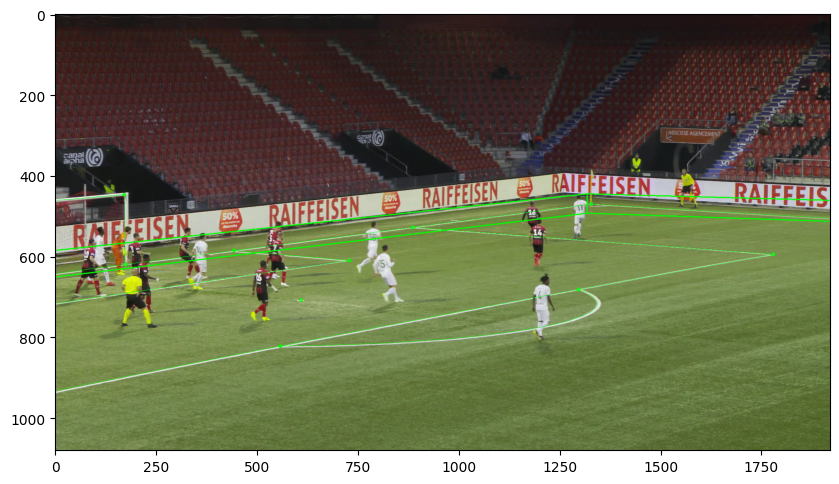

In [18]:
tmpImg = deepcopy(img)
for side in sides:
	if side == 'middle':
		y = imgWarpWindowDims[side]['closestTo0Y']
		leftx = imgWarpWindowDims['left']['closestTo0X'] if 'closestTo0X' in imgWarpWindowDims['left'] else -105/2
		rightx = imgWarpWindowDims['right']['closestTo0X'] if 'closestTo0X' in imgWarpWindowDims['right'] else 105/2
		pts = [[leftx, y, 0], [leftx, y, -maxz], [rightx, y, -maxz], [rightx, y, 0]]
		pts = np.array([cam.project_point(p, distort=False) for p in pts])[:, :2]
		cv2.polylines(tmpImg, [pts.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
	else:
		if 'closestTo0X' not in imgWarpWindowDims[side]:
			continue
		x = imgWarpWindowDims[side]['closestTo0X']
		y = imgWarpWindowDims['middle']['closestTo0Y'] if 'closestTo0Y' in imgWarpWindowDims['middle'] else 68/2
		pts = [[x, y, 0], [x, y, -maxz], [x, -y, -maxz], [x, -y, 0]]
		pts = np.array([cam.project_point(p, distort=False) for p in pts])[:, :2]
		cv2.polylines(tmpImg, [pts.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)

plt.imshow(cv2.cvtColor(tmpImg, cv2.COLOR_BGR2RGB))

## Preprocessing

In [19]:
for i in range(len(camParams)):
	if type(camParams[i]) == type(None):
		camParams[i] = camParams[i - 1]
	elif type(camParams[i]) == list:
		cam.from_json_parameters(camParams[i - 1])  # the homography won't give info about some camera parameters such as the distortions, so we take the previous camera parameters as a starting point
		cam.from_homography(camParams[i])
		camParams[i] = cam.to_json_parameters()

#### Smoothing

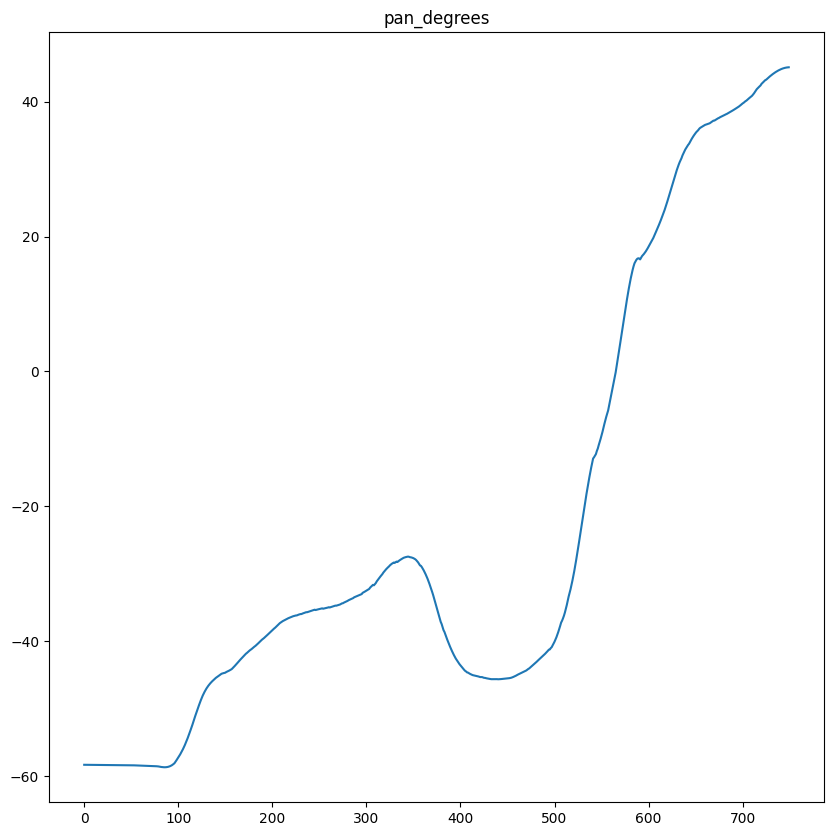

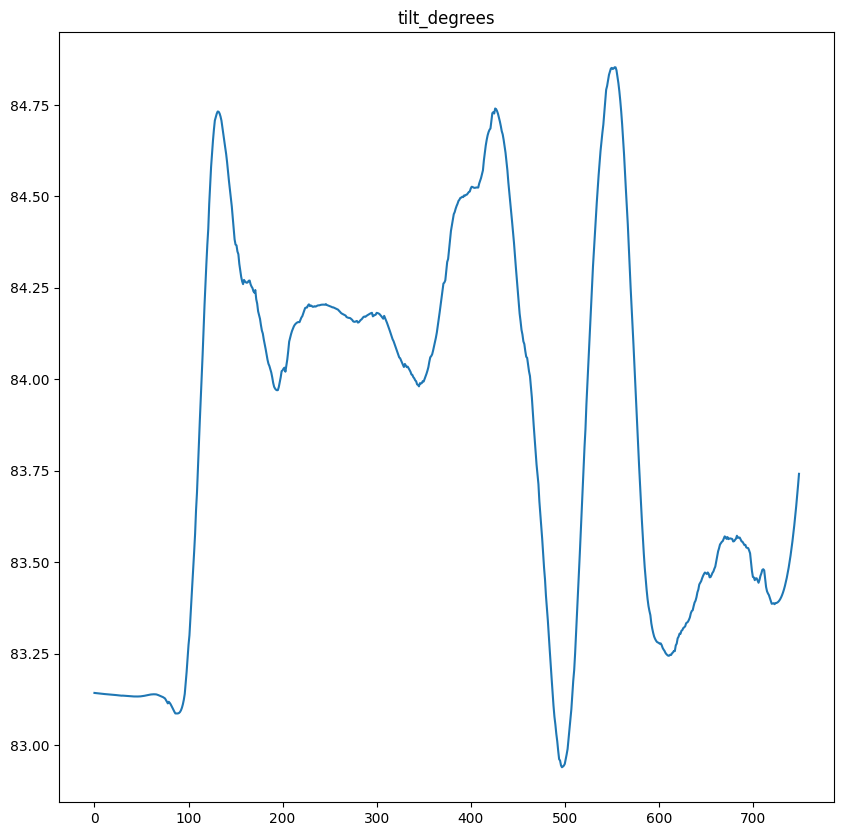

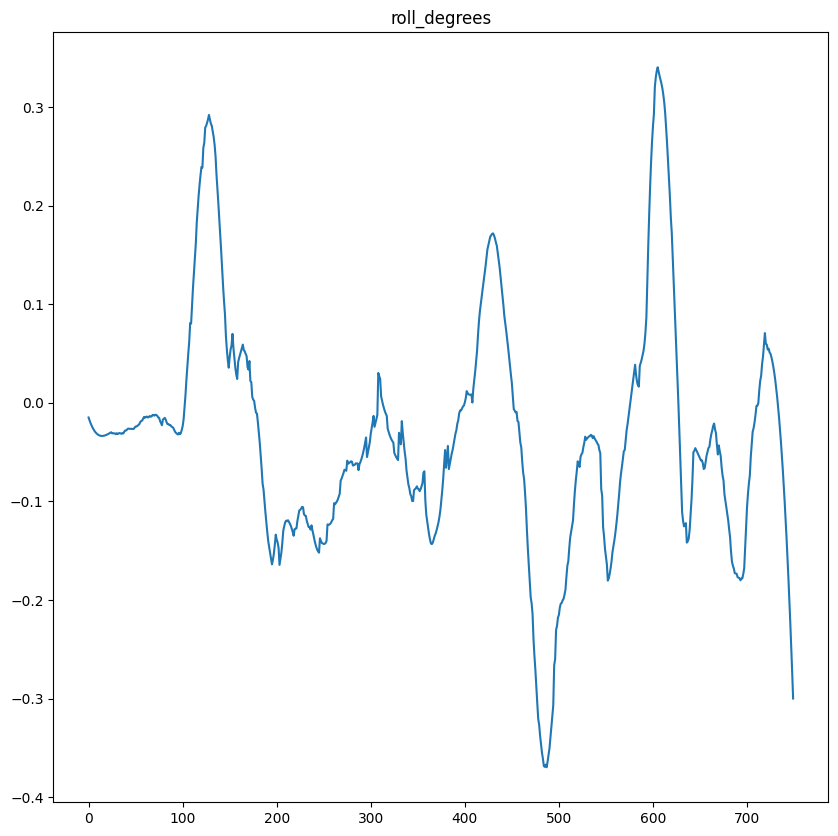

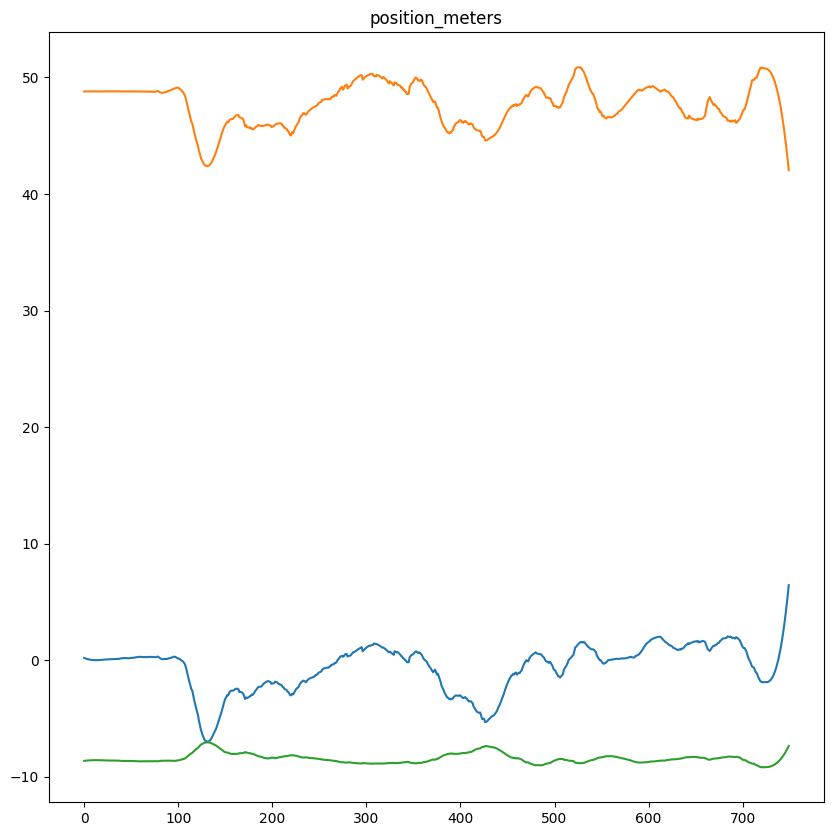

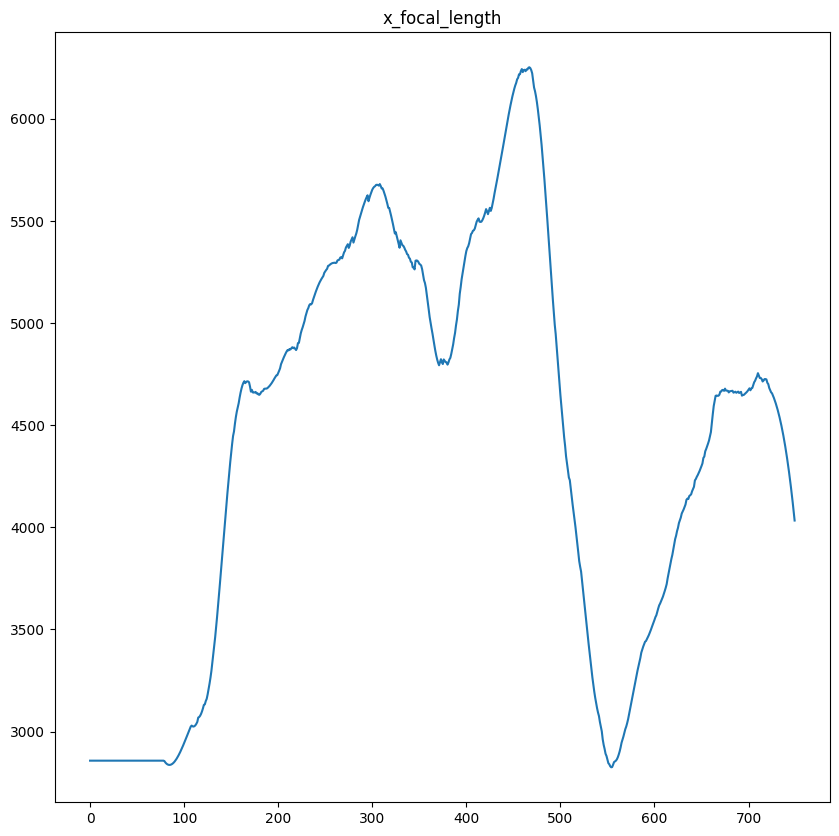

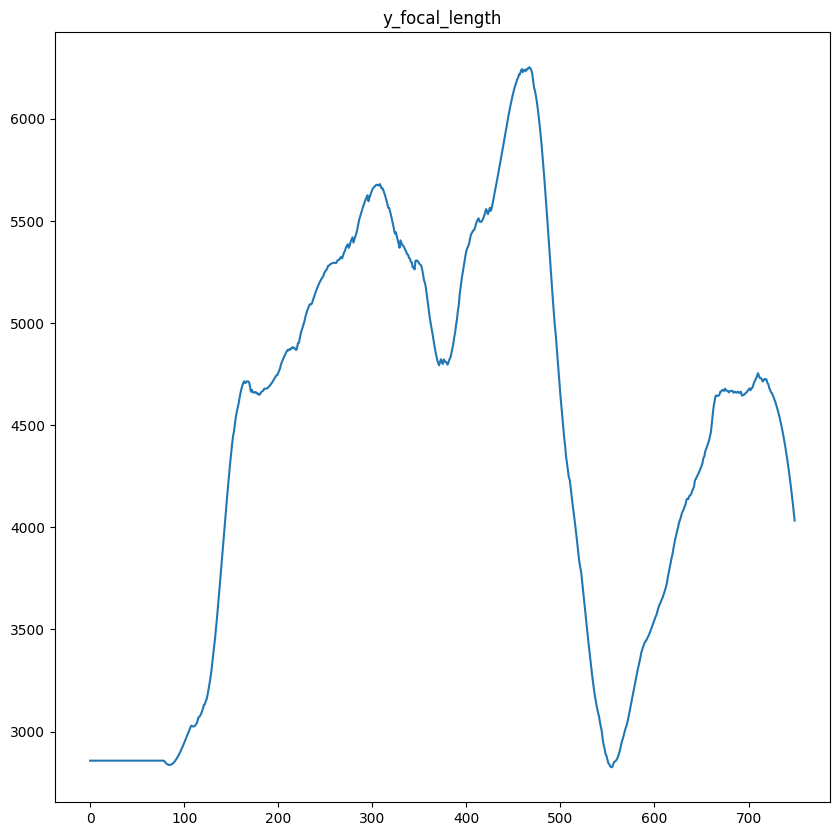

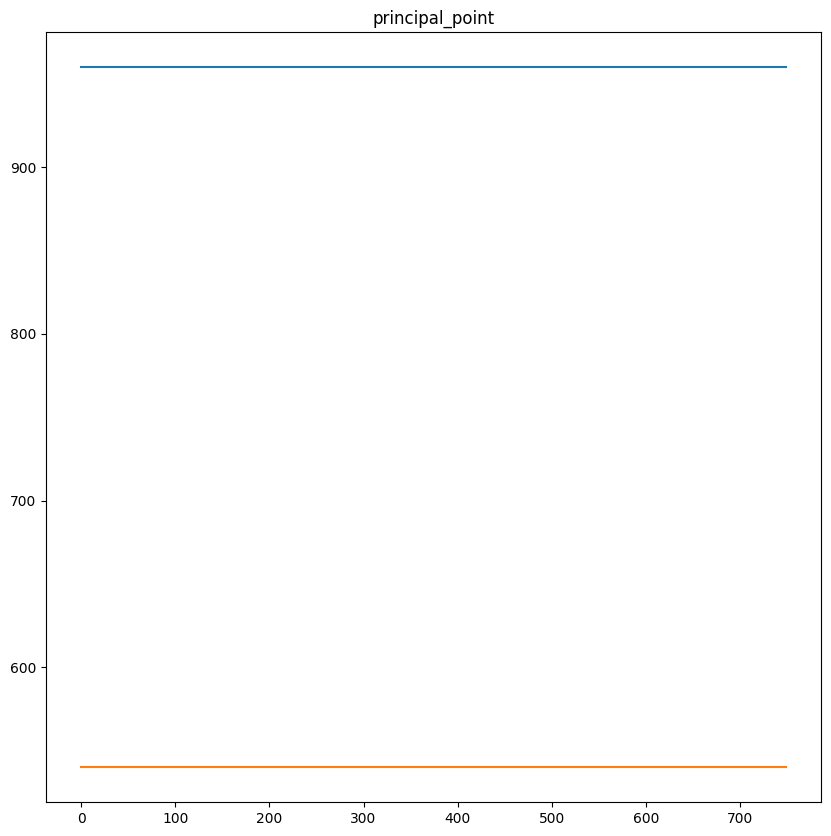

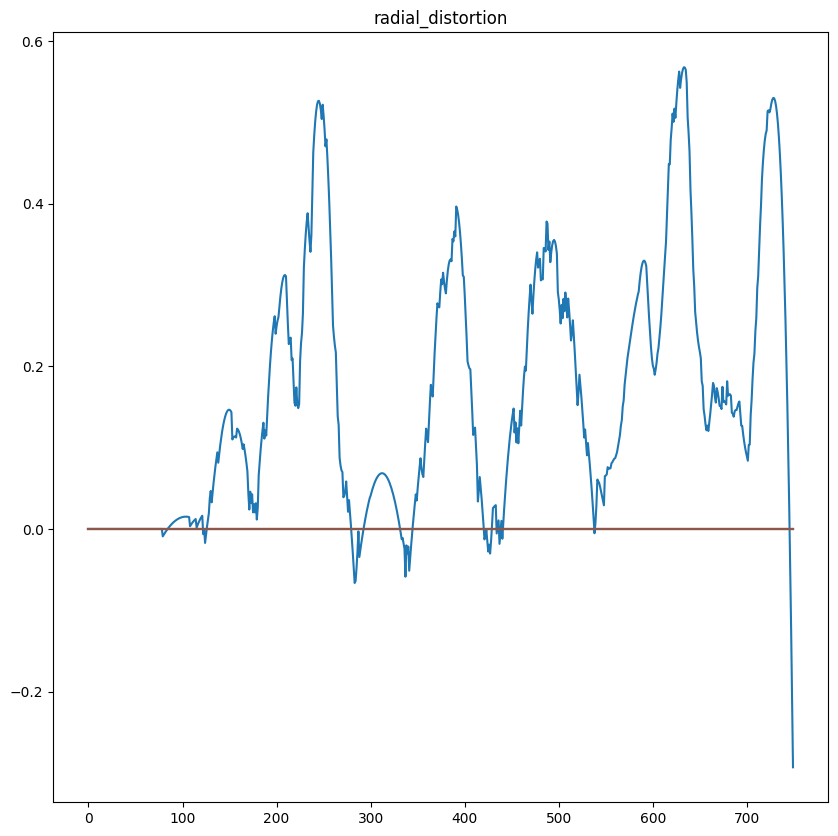

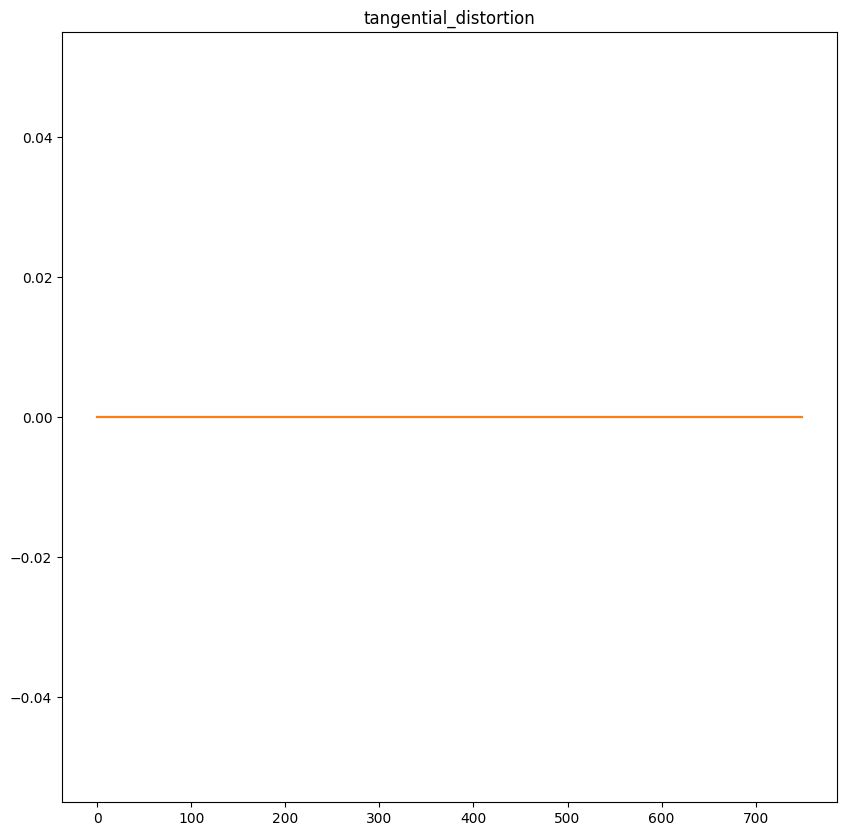

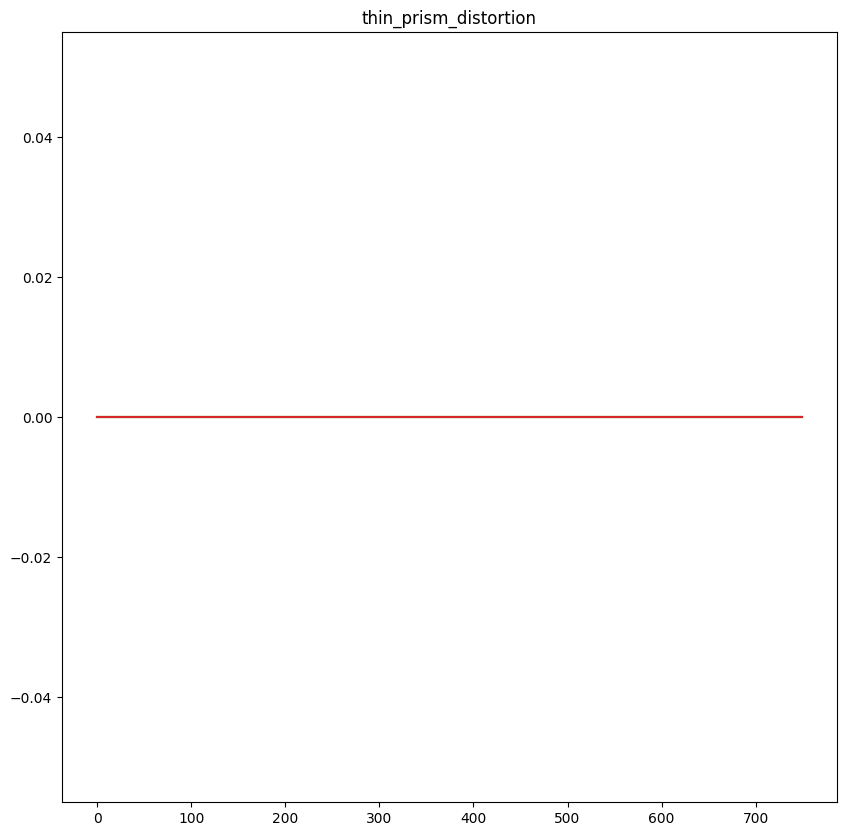

In [20]:
indCamParams = {
	"pan_degrees": [x["pan_degrees"] for x in camParams],
	"tilt_degrees": [x["tilt_degrees"] for x in camParams],
	"roll_degrees": [x["roll_degrees"] for x in camParams],
	"position_meters": [x["position_meters"] for x in camParams],
	"x_focal_length": [x["x_focal_length"] for x in camParams],
	"y_focal_length": [x["y_focal_length"] for x in camParams],
	"principal_point": [x["principal_point"] for x in camParams],
	"radial_distortion": [x["radial_distortion"] for x in camParams],
	"tangential_distortion": [x["tangential_distortion"] for x in camParams],
	"thin_prism_distortion": [x["thin_prism_distortion"] for x in camParams]
}
lngth = len(camParams)
smoothedIndCamParams = deepcopy(indCamParams)
for key in indCamParams.keys():
	smoothedIndCamParams[key] = scipy.signal.savgol_filter(indCamParams[key], 50, 3, axis=0)
smoothedCamParams = [dict(zip(smoothedIndCamParams.keys(), [smoothedIndCamParams[key][i] for key in smoothedIndCamParams.keys()])) for i in range(lngth)]
# change ndarray in the dict to list
for i in range(lngth):
	smoothedCamParams[i]["position_meters"] = smoothedCamParams[i]["position_meters"].tolist()
	smoothedCamParams[i]["principal_point"] = smoothedCamParams[i]["principal_point"].tolist()
	smoothedCamParams[i]["radial_distortion"] = np.abs(smoothedCamParams[i]["radial_distortion"]).tolist()
	smoothedCamParams[i]["tangential_distortion"] = np.abs(smoothedCamParams[i]["tangential_distortion"]).tolist()
	smoothedCamParams[i]["thin_prism_distortion"] = np.abs(smoothedCamParams[i]["thin_prism_distortion"]).tolist()
camParams = smoothedCamParams
for key in smoothedIndCamParams.keys():
	plt.plot(smoothedIndCamParams[key])
	plt.title(key)
	plt.show()

In [21]:
heights = np.zeros(750 * 1920, dtype=np.float64)
heightsArrayLen = 0
bannersDims = dict()
sides = ['left', 'middle', 'right']
for side in sides:
	bannersDims[side] = dict()
	bannersDims[side]['distArray'] = np.zeros_like(heights)
	bannersDims[side]['distArrayLen'] = 0

for i in tqdm(range(750)):
	cam.from_json_parameters(camParams[i])
	img = cv2.imread(imgPath + str(i+1).zfill(6) + '.jpg')
	mask = cv2.imread(maskPath + str(i+1).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
	binMask = np.uint8(mask > 0)
	firstNonZeroIdx = np.argmax(binMask, axis=0)
	colsWithNonZero = np.where(firstNonZeroIdx != 0)[0]
	flipped = cv2.flip(binMask, 0)
	flippedLastNonZeroIdx = np.argmax(flipped, axis=0)
	colsWithNonZero = np.union1d(colsWithNonZero, np.where(flippedLastNonZeroIdx != 0)[0])
	# colsWithNonZero is the set of columns that have at least one non-zero pixel in the mask and the non-zero pixels are not at the top or bottom of the image
	firstNonZeroIdx = firstNonZeroIdx[colsWithNonZero]
	flippedLastNonZeroIdx = flippedLastNonZeroIdx[colsWithNonZero]
	lastNonZeroIdx = mask.shape[0] - flippedLastNonZeroIdx - 1
	points2D = np.array([[x, y] for x, y in zip(colsWithNonZero, lastNonZeroIdx)])
	unprojectedPoints = np.array([cam.unproject_point_on_planeZ0(p, undistort=False) for p in points2D])
	unprojectedPoints[:, 2] = -1
	z1m = [cam.project_point(p, distort=False)[1] for p in unprojectedPoints]
	realz = (lastNonZeroIdx - firstNonZeroIdx) / (lastNonZeroIdx - z1m)
	heights[heightsArrayLen:heightsArrayLen + realz.shape[0]] = realz
	heightsArrayLen += realz.shape[0]

	for side in sides:
		if side == 'middle':
			pts = np.bitwise_and(unprojectedPoints[:, 0] >= -105/2, unprojectedPoints[:, 0] <= 105/2)
			pts = unprojectedPoints[pts][:, 1]
			if pts.shape[0] == 0:
				continue
			bannersDims[side]['distArray'][bannersDims[side]['distArrayLen']:bannersDims[side]['distArrayLen'] + pts.shape[0]] = pts
			bannersDims[side]['distArrayLen'] += pts.shape[0]
		else:
			pts = np.bitwise_and(unprojectedPoints[:, 1] >= -68/2, unprojectedPoints[:, 1] <= 68/2)
			pts = np.bitwise_and(pts, unprojectedPoints[:, 0] < 0 if side == 'left' else unprojectedPoints[:, 0] > 0)
			pts = unprojectedPoints[pts][:, 0]
			if pts.shape[0] == 0:
				continue
			bannersDims[side]['distArray'][bannersDims[side]['distArrayLen']:bannersDims[side]['distArrayLen'] + pts.shape[0]] = pts
			bannersDims[side]['distArrayLen'] += pts.shape[0]

  0%|          | 0/750 [00:00<?, ?it/s]

100%|██████████| 750/750 [01:22<00:00,  9.04it/s]


In [22]:
heights = heights[:heightsArrayLen]
np.mean(heights), np.std(heights)

(0.972684521971611, 0.10131086714979541)

In [23]:
height = np.mean(heights)
height

0.972684521971611

In [24]:
for side in sides:
	bannersDims[side]['distArray'] = bannersDims[side]['distArray'][:bannersDims[side]['distArrayLen']]
	bannersDims[side]['dist'] = np.mean(bannersDims[side]['distArray'])
	print(side, bannersDims[side]['dist'], np.std(bannersDims[side]['distArray']))

left -57.221015632078014 0.8243122518571552
middle -38.483439171658524 1.3895379053141408
right 57.16074779933362 0.4404192567873783


In [25]:
for side in sides:
	bannersDims[side]['distArray'] = bannersDims[side]['distArray'][:bannersDims[side]['distArrayLen']]
	bannersDims[side]['distArray'] = np.mean(bannersDims[side]['distArray'])

In [26]:
bannersDims

{'left': {'distArray': -57.221015632078014,
  'distArrayLen': 617101,
  'dist': -57.221015632078014},
 'middle': {'distArray': -38.483439171658524,
  'distArrayLen': 383192,
  'dist': -38.483439171658524},
 'right': {'distArray': 57.16074779933362,
  'distArrayLen': 162863,
  'dist': 57.16074779933362}}

In [27]:
bannersDim = ((bannersDims['left']['distArray'], 68/2), (bannersDims['left']['distArray'], bannersDims['middle']['distArray']), (bannersDims['right']['distArray'], bannersDims['middle']['distArray']), (bannersDims['right']['distArray'], 68/2))
bannersDim

((-57.221015632078014, 34.0),
 (-57.221015632078014, -38.483439171658524),
 (57.16074779933362, -38.483439171658524),
 (57.16074779933362, 34.0))

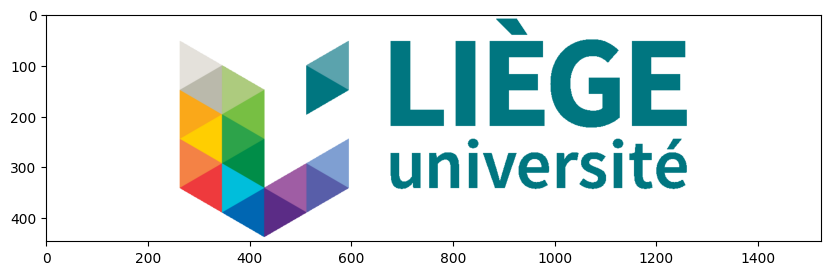

In [28]:
logo = cv2.imread('University_of_Liège_logo.png')
logo = cv2.copyMakeBorder(logo, 0, 0, logo.shape[1]//4, logo.shape[1]//4, cv2.BORDER_CONSTANT, value=(255, 255, 255))
plt.imshow(cv2.cvtColor(logo, cv2.COLOR_BGR2RGB))

I need to resize to a width of 30000 or else cv2.warpPerspective won't work. But by doing so the height will shrink and might be smaller than the width of the banner in the image, resulting in a loss of resolution and possibly visible pixels. Will have to figure sg. Maybe simply multiple warping to avoid a resizing ?

In [29]:
logo.shape

(446, 1525, 3)

3.3258831749029305
bannerBeginning: 0
76.96687834331705 1525 3.3258831749029305 23.14178649572182 23 35291.22440597578
cut: 216
(396, 32766, 3)
bannerBeginning: 216
113.91068751942538 1525 3.3258831749029305 34.24975608854631 34 52230.87803503313
cut: 381
(272, 32766, 3)
bannerBeginning: 381
76.1359527763413 1525 3.3258831749029305 22.89195043014805 22 34910.22440597578
cut: 1360
(405, 32766, 3)


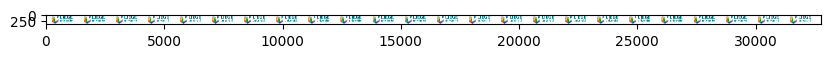

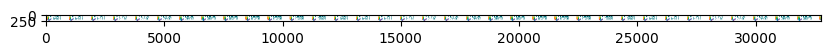

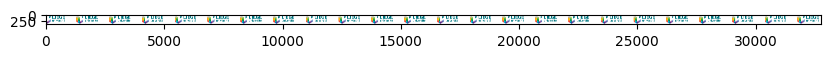

In [30]:
logoBanners = dict()
cut = 0
logoWidthInMeters = height * (logo.shape[1] / logo.shape[0])
print(logoWidthInMeters)
for side in sides:
	if side == 'middle':
		logoBannerLen = bannersDims['right']['distArray'] - bannersDims['left']['distArray']
	else:
		logoBannerLen = -2 * bannersDims['middle']['distArray']
	bannerBeginning = cut
	print('bannerBeginning:', bannerBeginning)
	logoBannerLen -= (bannerBeginning / logo.shape[1]) * logoWidthInMeters

	print(logoBannerLen, logo.shape[1], logoWidthInMeters, logoBannerLen / logoWidthInMeters, np.floor(logoBannerLen / logoWidthInMeters).astype(np.int32), logoBannerLen / logoWidthInMeters * logo.shape[1])
	nLogosInBanner = np.floor(logoBannerLen / logoWidthInMeters).astype(np.int32)
	rest = logoBannerLen / logoWidthInMeters - nLogosInBanner
	cut = np.round(rest * logo.shape[1]).astype(np.int32)
	print('cut:', cut)
	# print(np.round(rest * logo.shape[1]).astype(np.int32))
	tmpBanner = np.concatenate([logo[:, bannerBeginning:]] + [logo for _ in range(nLogosInBanner)] + [logo[:, :cut]], axis=1)
	if tmpBanner.shape[1] >= 32766:
		# Resize to a width of 32766 pixels, keep the aspect ratio
		tmpBanner = cv2.resize(tmpBanner, (32766, int(32766 * (tmpBanner.shape[0] / tmpBanner.shape[1]))))
	plt.figure()
	plt.imshow(cv2.cvtColor(tmpBanner, cv2.COLOR_BGR2RGB))
	print(tmpBanner.shape)
	logoBanners[side] = tmpBanner

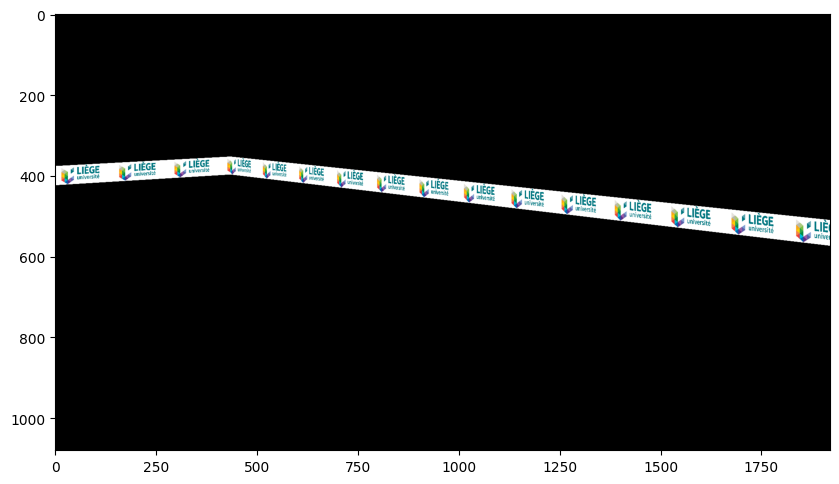

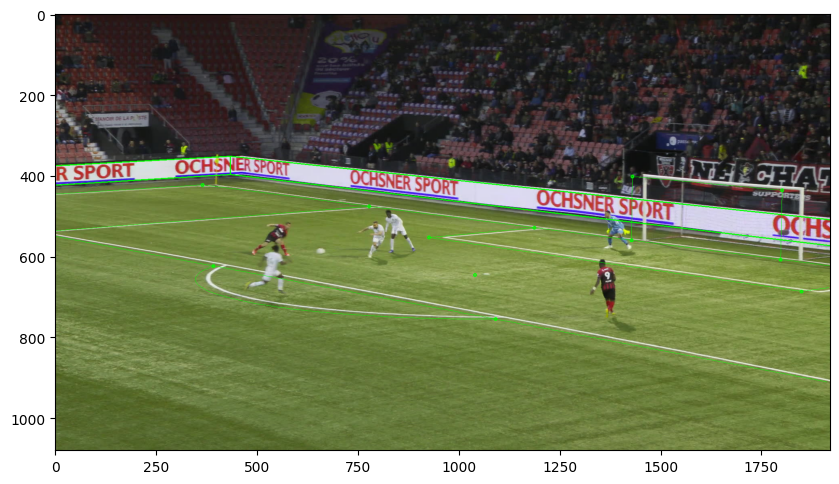

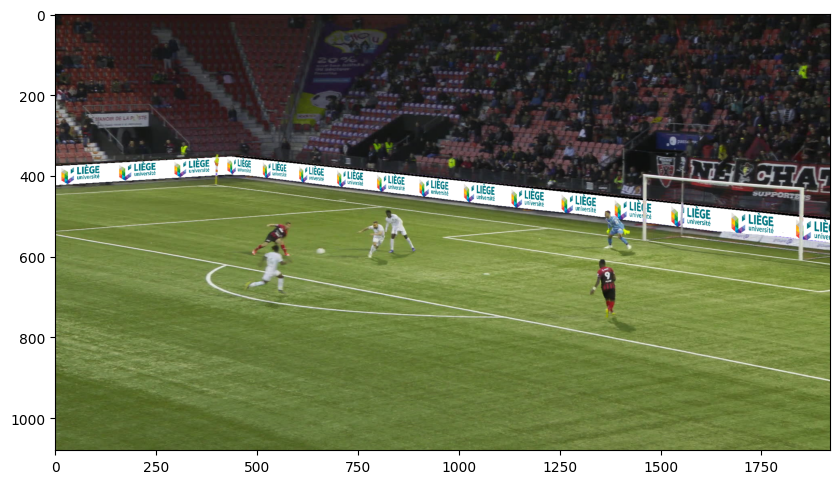

In [140]:
imgNum = 700
cam.from_json_parameters(camParams[imgNum - 1])
img = cv2.imread(imgPath + str(imgNum).zfill(6) + '.jpg')
mask = cv2.imread(maskPath + str(imgNum).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
tmp = np.zeros_like(img)
for side in sides:
	if side == 'middle':
		leftx = bannersDims['left']['distArray']
		rightx = bannersDims['right']['distArray']
		y = bannersDims[side]['distArray']
		pts = [[leftx, y, 0], [leftx, y, -height], [rightx, y, -height], [rightx, y, 0]]
		pts = np.array([cam.project_point(p, distort=False) for p in pts])[:, :2]
		pts[1][0] = pts[0][0]
		pts[2][0] = pts[3][0]
		if np.any(pts == 0):  # pts are not in the image
			continue
		cv2.polylines(img, [pts.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
		tmpHeight, tmpWidth = logoBanners[side].shape[:2]
		srcPts = np.array([[0, tmpHeight], [0, 0], [tmpWidth, 0], [tmpWidth, tmpHeight]], dtype=np.float32)
		dstPts = np.array(pts, dtype=np.float32)
		M = cv2.getPerspectiveTransform(srcPts, dstPts)
		tmp = cv2.bitwise_or(tmp, cv2.warpPerspective(logoBanners[side], M, (img.shape[1], img.shape[0])))
	else:
		x = bannersDims[side]['distArray']
		y = bannersDims['middle']['distArray']
		if side == 'right':
			y = -y
		pts = [[x, -y, 0], [x, -y, -height], [x, y, -height], [x, y, 0]]
		pts = np.array([cam.project_point(p, distort=False) for p in pts])[:, :2]
		pts[1][0] = pts[0][0]
		pts[2][0] = pts[3][0]
		if np.any(pts == 0):  # pts are not in the image
			continue
		cv2.polylines(img, [pts.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
		tmpHeight, tmpWidth = logoBanners[side].shape[:2]
		srcPts = np.array([[0, tmpHeight], [0, 0], [tmpWidth, 0], [tmpWidth, tmpHeight]], dtype=np.float32)
		dstPts = np.array(pts, dtype=np.float32)
		M = cv2.getPerspectiveTransform(srcPts, dstPts)
		tmp = cv2.bitwise_or(tmp, cv2.warpPerspective(logoBanners[side], M, (img.shape[1], img.shape[0])))

cam.draw_pitch(img)
cam.draw_corners(img)
plt.imshow(cv2.cvtColor(tmp	, cv2.COLOR_BGR2RGB))
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
binMask = np.bitwise_and(mask > 0, mask < 3)
img = cv2.imread(imgPath + str(imgNum).zfill(6) + '.jpg')
tmpImg = deepcopy(img)
tmpImg[binMask] = tmp[binMask]
plt.figure()
plt.imshow(cv2.cvtColor(tmpImg, cv2.COLOR_BGR2RGB))

In [141]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  #type: ignore
out = cv2.VideoWriter('360_video_with_logo_50.mp4', fourcc, 25, (1920, 1080))

for i in tqdm(range(750)):
	cam.from_json_parameters(camParams[i])
	img = cv2.imread(imgPath + str(i+1).zfill(6) + '.jpg')
	mask = cv2.imread(maskPath + str(i+1).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
	tmp = np.zeros_like(img)
	for side in sides:
		if side == 'middle':
			leftx = bannersDims['left']['distArray']
			rightx = bannersDims['right']['distArray']
			y = bannersDims[side]['distArray']
			pts = [[leftx, y, 0], [leftx, y, -height], [rightx, y, -height], [rightx, y, 0]]
			pts = np.array([cam.project_point(p, distort=False) for p in pts])[:, :2]
			pts[1][0] = pts[0][0]
			pts[2][0] = pts[3][0]
			if np.any(pts == 0):  # pts are not in the image
				continue
			# cv2.polylines(img, [pts.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
			tmpHeight, tmpWidth = logoBanners[side].shape[:2]
			srcPts = np.array([[0, tmpHeight], [0, 0], [tmpWidth, 0], [tmpWidth, tmpHeight]], dtype=np.float32)
			dstPts = np.array(pts, dtype=np.float32)
			M = cv2.getPerspectiveTransform(srcPts, dstPts)
			tmp = cv2.bitwise_or(tmp, cv2.warpPerspective(logoBanners[side], M, (img.shape[1], img.shape[0])))
		else:
			x = bannersDims[side]['distArray']
			y = bannersDims['middle']['distArray']
			if side == 'right':
				y = -y
			pts = [[x, -y, 0], [x, -y, -height], [x, y, -height], [x, y, 0]]
			pts = np.array([cam.project_point(p, distort=False) for p in pts])[:, :2]
			pts[1][0] = pts[0][0]
			pts[2][0] = pts[3][0]
			if np.any(pts == 0):  # pts are not in the image
				continue
			# cv2.polylines(img, [pts.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
			tmpHeight, tmpWidth = logoBanners[side].shape[:2]
			srcPts = np.array([[0, tmpHeight], [0, 0], [tmpWidth, 0], [tmpWidth, tmpHeight]], dtype=np.float32)
			dstPts = np.array(pts, dtype=np.float32)
			M = cv2.getPerspectiveTransform(srcPts, dstPts)
			tmp = cv2.bitwise_or(tmp, cv2.warpPerspective(logoBanners[side], M, (img.shape[1], img.shape[0])))
	binMask = np.bitwise_and(mask > 0, mask < 3)
	img[binMask] = tmp[binMask]
	cam.draw_corners(cam.draw_pitch(img))
	out.write(img)

out.release()

100%|██████████| 750/750 [01:23<00:00,  8.97it/s]
